# Evaluating Relevant Features

## Part 1: Imports
### Import Required Packages

In [182]:
import numpy    as np
import pandas   as pd
import re
import os
import sys
import seaborn as sns 
import yellowbrick as yb
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings

## Sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import Imputer, FunctionTransformer, StandardScaler
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression, Lasso, RidgeClassifier
from sklearn.model_selection import train_test_split


## YellowBrick
from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank2D
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features import Rank1D, Rank2D
from yellowbrick.features.importances import FeatureImportances
from sklearn.linear_model import LassoCV




### Change Defaults

In [113]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

### Import Custom Functions & Data

In [114]:
wd = os.getcwd()
mod_dir     = wd + '/../custom_modules/'
sys.path.insert(0, mod_dir)
import cleaning_helpers as helpers

In [115]:
path = wd + '/../../../med_school_data/output/'
file_name = 'final_data.csv'

def load_data(csv, path):
	df = pd.read_csv(path + csv)
	return df

data = load_data(file_name, path)
data.head()

,m1_fall,mcat_zscore,mcat_total_attempts,bachelor_1,bachelor_2,bachelor_3,master_1,master_2,master_3,associate_1,associate_2,biochem_likelyhood,gem_indicator,race,gender,m1f_limbs,m1f_metabolism_nutrition_and_endo,m1f_molecular_and_cell_physiology,m1f_molecular_and_human_genetics,m1s_cardio_pulmonary,m1s_ebm_and_population_health,m1s_gastrointestinal,m1s_head_neck_and_special_senses,m1s_patients_populations_and_policy,m1s_physical_diagnosis_i,m1s_renal_and_electrolytes,m1s_sexual_dev__and_reproduction,m2s_clinical_skills_primer,m2s_evidence_based_medicine_ii,m2s_health_care_ethics,m2s_human_sexuality,m2s_lab_medicine_pblm_solving_case,m2s_microbiology_and_immunology,m2s_pathology,m2s_pharmacology,m2s_physical_diagnosis_ii,m2s_psychiatry,step1_z_score,step1_pass_indicator,step1_total_attempts,target_indicator,double_bachelor,master_degree,double_master,associate_degree,science_undergrad,science_master,bachelors_num,science_bachelors_num,masters_num,science_masters_num,GPA,step1_rank,step1_total_students,step1_percentile,step1_low_score,danger_student
0,2009,2.505529,1.0,Science,missing,missing,Science,missing,missing,missing,missing,4.0,0.0,White,M,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,1.0,4.0,4.0,3.0,2.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,3.0,2.178880,1.0,1.0,0,0,1,0,0,1,1,1.0,1.0,1,1,3.380952,203.0,203.0,1.000000,0,0
1,2009,-1.407328,2.0,Science,missing,missing,Science,missing,missing,Science,missing,1.0,1.0,Black or African American,F,2.0,3.0,2.0,2.0,4.0,2.0,4.0,2.0,3.0,1.0,4.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,-0.836599,1.0,1.0,0,0,1,0,1,1,1,1.0,1.0,1,1,2.333333,28.0,203.0,0.137931,1,1
2,2009,0.745614,1.0,Arts,missing,missing,missing,missing,missing,missing,missing,3.0,0.0,White,M,2.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,2.0,2.0,2.0,1.0,2.0,0.747805,1.0,1.0,0,0,0,0,0,0,0,1.0,1.0,0,0,2.428571,156.5,203.0,0.770936,0,0
3,2009,0.149933,1.0,Science,missing,missing,missing,missing,missing,missing,missing,4.0,0.0,White,M,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,3.0,1.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,-0.121062,1.0,1.0,0,0,0,0,0,1,0,1.0,1.0,0,0,2.714286,75.0,203.0,0.369458,0,0
4,2009,-0.973841,1.0,Science,missing,missing,missing,missing,missing,missing,missing,4.0,1.0,Asian,F,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,-1.501027,1.0,1.0,0,0,0,0,0,1,0,1.0,1.0,0,0,2.055556,8.0,203.0,0.039409,1,1


### Make Feature Lists
Sometimes it's nice to iterate through different types of variables, so these predefined lists will just make things a little bit easier for us

In [95]:
courses = ['m1f_limbs', 'm1f_metabolism_nutrition_and_endo', 
        'm1f_molecular_and_cell_physiology',
        'm1f_molecular_and_human_genetics','m1s_cardio_pulmonary', 
        'm1s_ebm_and_population_health','m1s_gastrointestinal', 
        'm1s_head_neck_and_special_senses', 'm1s_patients_populations_and_policy',
           'm1s_renal_and_electrolytes', 
        'm1s_sexual_dev__and_reproduction']

categorical = ['race', 'gender']


indicators = ['gem_indicator', 'double_bachelor', 'double_master', 'master_degree',
              'associate_degree', 'science_undergrad', 'science_master']

continuous = ['mcat_zscore']

discontinuous = ['mcat_total_attempts', 'biochem_likelyhood']

target_elements = ['danger_student']




## Part Two: Make Necessary Transformations
### Encode Class Failures 
Since there can be some abiguity when it comes to grades, and we aren't sure if some classes are graded differently than others, the Dean of the Medical School has suggested that we break the course grades simply into fail pass (1/0).  

In [45]:
class PassFail(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None):
        self.columns  = [col for col in columns] 
        self.encoders = None
            
    def fit(self, data, target=None):
        if self.columns is None:
            self.columns = data[courses].columns 
        return self
    
    def transform(self, data):
        output = data.copy()
        graded_courses = []
        for col in self.columns:
            if output[col].nunique() > 2:
                indicator = col + '_low_ind'
                output[indicator] = np.where(output[col] <=2, 1, 0)
                graded_courses.append(indicator)
        return output

In [46]:
class MakeDummies(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None):
        self.columns  = [col for col in columns] 
        self.encoders = None
            
    def fit(self, data, target=None):
        if self.columns is None:
            self.columns = data.columns 
        return self
    
    def transform(self, data):
        output = data.copy()
        for col in self.columns:
            output = pd.get_dummies(data = output, columns = [col])
        return output

## Part 3: Parallel Coordinates Plots
Since we only really have two continuous variables (GPA and MCAT Zscore), these plots are basically just going to show:
- Do MCAT score and GPA predict who will pass or fail? (This is pretty obvious, and more of just a sanity check).
- If we subset the data based on specific indicator variables, is do we seen any changes in the relatioship between these variables. (For example: Are MCAT and Grades better predictors for Science Majors?)

### Make the Transformations

In [47]:
PF = PassFail(courses)
plot_data = PF.fit_transform(data)

### Set Some Defaults

In [48]:
features = ['mcat_zscore', 'GPA']
classes = ['Step One >25th Percentile','Step One < 25th Percentile (Or Fail)']
low_indicators = [col for col in plot_data if col.endswith('low_ind')]

### Parallel Coordinates Function
This will be a function that we can easily run to produce a parallel coordinates plot for various subgroups of data

In [49]:
def PCords(data, features = features, classes = classes, output = False):
    X = data[features].as_matrix()
    y = data.danger_student.as_matrix()

    visualizer = ParallelCoordinates(classes = classes,
            features = features)

    visualizer.fit(X,y)
    visualizer.transform(X)
    if output == True:    
        visualizer.title = 'Parallel Coordinates: MCAT vs. Med School GPA'
        visualizer.poof(outpath = './visuals/PCoords.png')
    else:
        visualizer.poof()

    

### Plot 1A: Full Sample
Unsurprisingly, we see that students who struggle with Step One tend to have lower MCAT scores and GPAs than the students who pass. Groundbreaking!

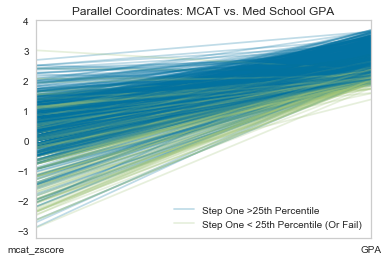

In [50]:
import matplotlib
#matplotlib.rcParams['figure.figsize'] = [18,16]
PCords(plot_data, output = True)

### Plot 1B:  Filter on Low Grades
Nothing super interesting here. We were hoping to see one or two particular courses that could really predict whether or not a student might fail the program. It looks like students that have a lower score in m1s_renal_and_electrolytes might have a higher chance of struggling step one based on the number of green lines in the plot, but this might just be an illusion. We will think about this a little more when it comes time to do the actual machine learning

Making the PCords chart for subsets of students who got a 2 or lower grade in the respective class

Subset: m1f_limbs_low_ind = 1 


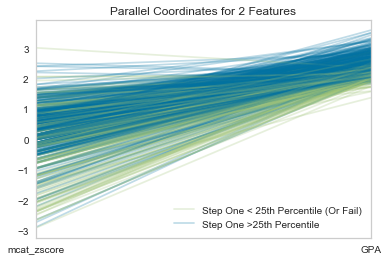


Subset: m1f_metabolism_nutrition_and_endo_low_ind = 1 


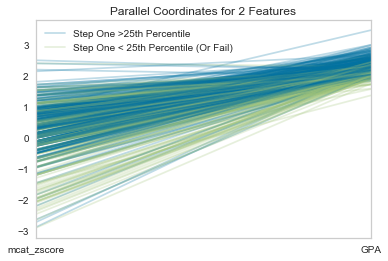


Subset: m1f_molecular_and_cell_physiology_low_ind = 1 


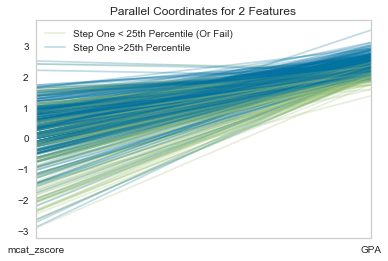


Subset: m1f_molecular_and_human_genetics_low_ind = 1 


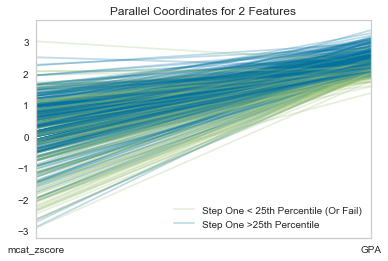


Subset: m1s_cardio_pulmonary_low_ind = 1 


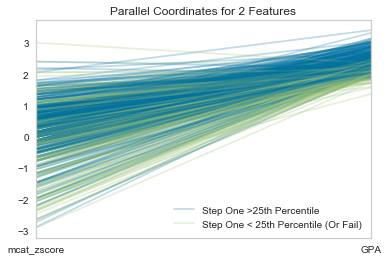


Subset: m1s_ebm_and_population_health_low_ind = 1 


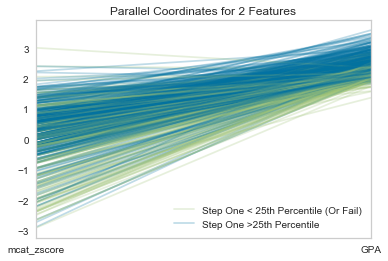


Subset: m1s_gastrointestinal_low_ind = 1 


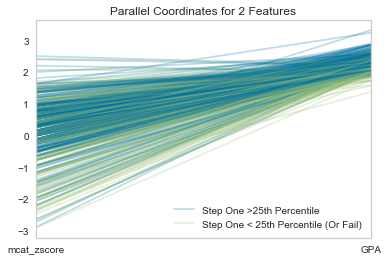


Subset: m1s_head_neck_and_special_senses_low_ind = 1 


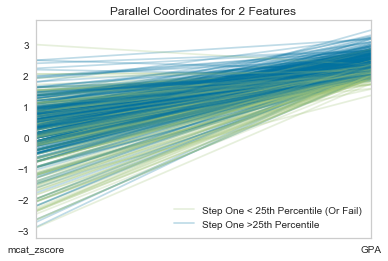


Subset: m1s_patients_populations_and_policy_low_ind = 1 


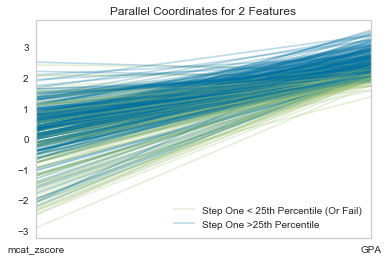


Subset: m1s_renal_and_electrolytes_low_ind = 1 


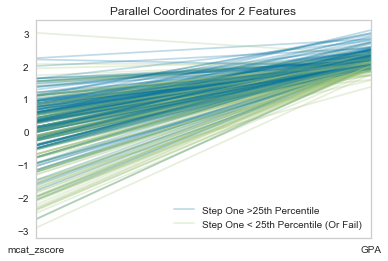


Subset: m1s_sexual_dev__and_reproduction_low_ind = 1 


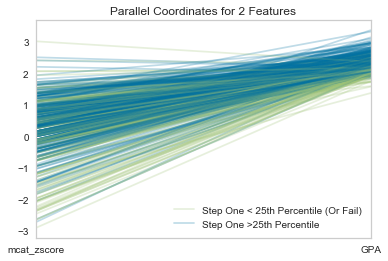

In [51]:
print('Making the PCords chart for subsets of students who got a 2 or lower grade in the respective class')
for flag in low_indicators:
    print('\nSubset: ' + flag + ' = 1 ')
    PCords(plot_data[plot_data[flag] == 1])

### Plot 1C:  Filter on High Grades
These Charts aren't super interesting either. It looks like the last three courses might have more failures than others. This could mean that those courses are easier than the others, since they don't correlate as well with passing Step One. Though this could definitely be a little bit of a stretch. Gastro looks like it might be a decent predictor for passing step one based changes in the plots. 

Making the PCords chart for subsets of students who got a 2 or lower grade in the respective class

Subset: m1f_limbs_low_ind = 0 


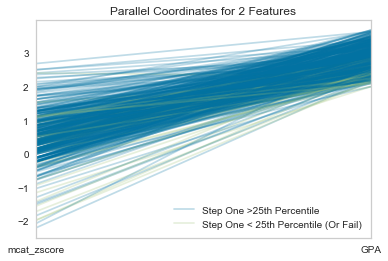


Subset: m1f_metabolism_nutrition_and_endo_low_ind = 0 


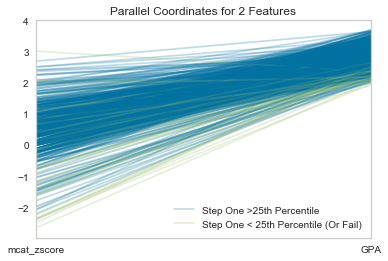


Subset: m1f_molecular_and_cell_physiology_low_ind = 0 


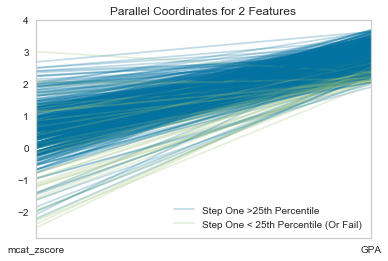


Subset: m1f_molecular_and_human_genetics_low_ind = 0 


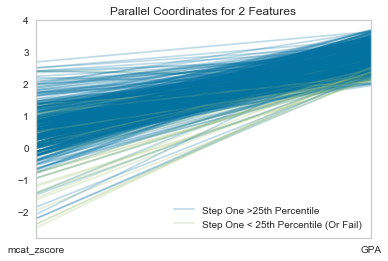


Subset: m1s_cardio_pulmonary_low_ind = 0 


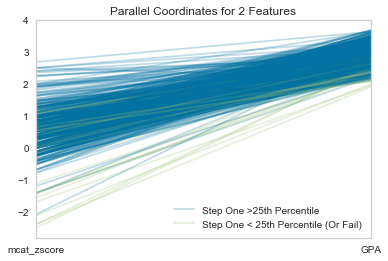


Subset: m1s_ebm_and_population_health_low_ind = 0 


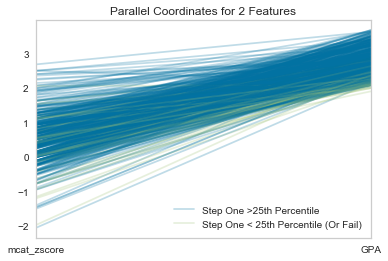


Subset: m1s_gastrointestinal_low_ind = 0 


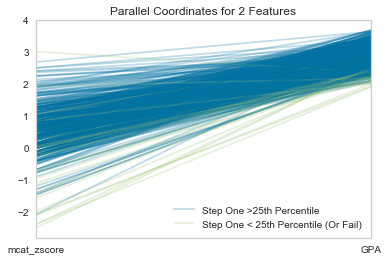


Subset: m1s_head_neck_and_special_senses_low_ind = 0 


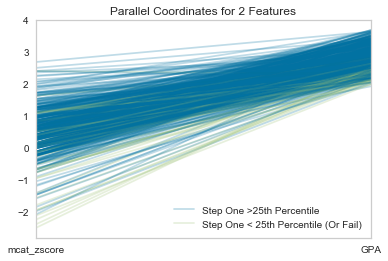


Subset: m1s_patients_populations_and_policy_low_ind = 0 


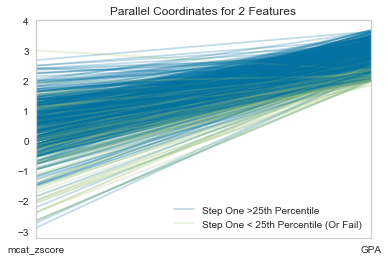


Subset: m1s_renal_and_electrolytes_low_ind = 0 


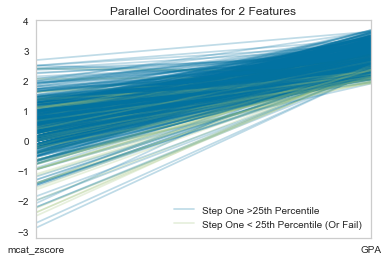


Subset: m1s_sexual_dev__and_reproduction_low_ind = 0 


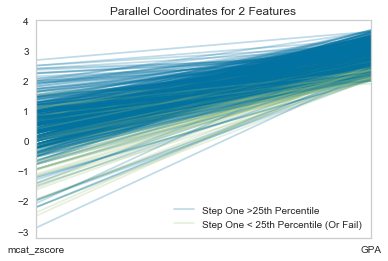

In [52]:
print('Making the PCords chart for subsets of students who got a 2 or lower grade in the respective class')
for flag in low_indicators:
    print('\nSubset: ' + flag + ' = 0 ')
    PCords(plot_data[plot_data[flag] == 0])

### Plot 1D:  Filter Demographics
Here we'll take a look at what these plots look like for different demographic subgroups of people. 

#### Disclaimer:
It's important to note here that we aren't interested in whether or certain demographics are more or less prone to failing Step One. More generally, for ethical reasons we are not trying to make any statements about which subgroups of people perform the best on Step One, MCAT, GPA, etc. This would not be useful for Georgetown or anyone. 

The true goal here is to see how good of a PREDICTOR MCAT and GPA are for certain subgroups of people. Meaning, do the different colored lines separate more clearly for specific groups of people. 

PCords Plot for Male Students


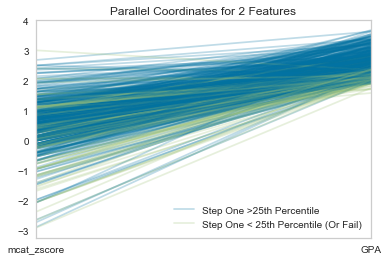

In [60]:
print('PCords Plot for Male Students')
PCords(plot_data[plot_data['gender']=='M'])

PCords Plot for Female Students


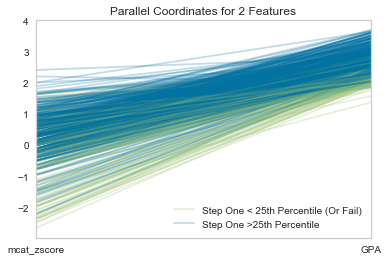

In [61]:
print('PCords Plot for Female Students')
PCords(plot_data[plot_data['gender']=='F'])

Creating Parallel Coordinates Charts for all Races
Race : White


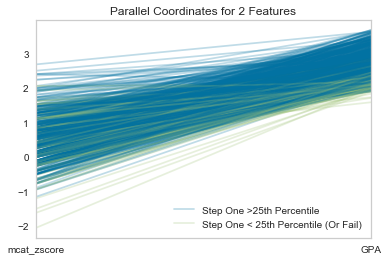

Race : Black or African American


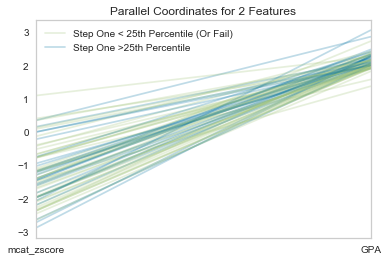

Race : Asian


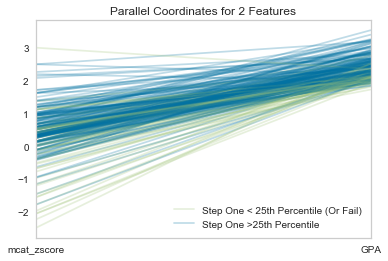

Race : Unknown


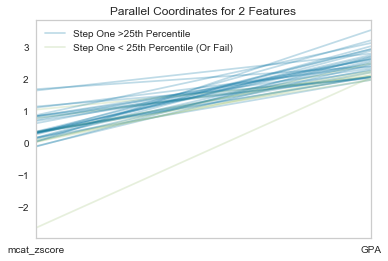

Race : Hispanic


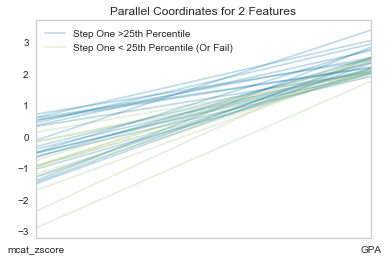

Race : Two or More Races


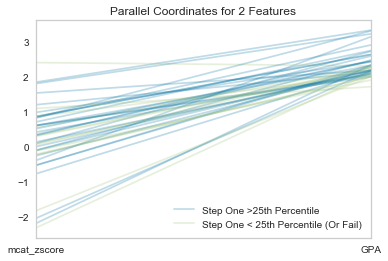

Race : Amer. Indian or Alaska Nat.


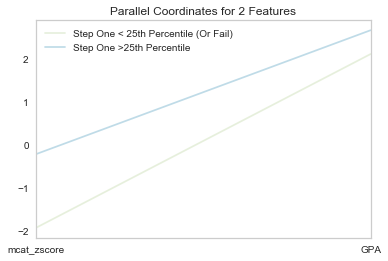

In [62]:
print('Creating Parallel Coordinates Charts for all Races')
race_list = list(plot_data.race.unique())
for race in race_list:
    print('Race : ' + race)
    PCords(plot_data[plot_data.race == race])

### Plot 1E:  Filter Academic History
Last but not least, let's take a look at how our two main predictors work for groups of students with different academic history



Students with a LOW likelyhood of biochem experience


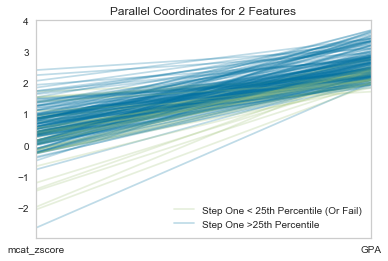

Students with a HIGH likelyhood of biochem experience


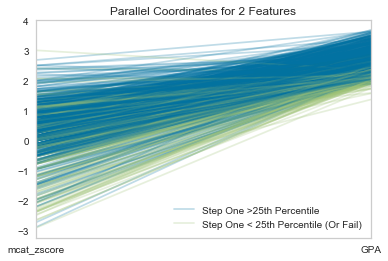

In [66]:
print('Students with a LOW likelyhood of biochem experience')
PCords(plot_data[plot_data.biochem_likelyhood <= 2])
print('Students with a HIGH likelyhood of biochem experience')
PCords(plot_data[plot_data.biochem_likelyhood > 2])

Students with a masters degree


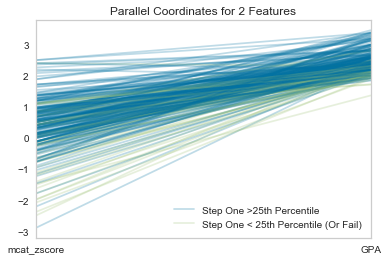

In [67]:
print('Students with a masters degree')
PCords(data[data.master_1 != 'missing'])

Students without a masters degree


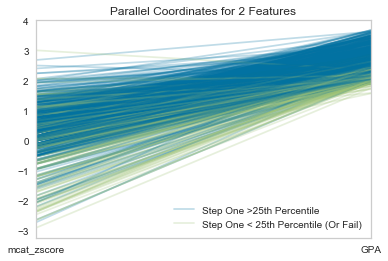

In [68]:
print('Students without a masters degree')
PCords(data[data.master_1 == 'missing'])

### Parallel Coordinates Conclusion:
I'm not particularly drawn to any of these charts. For most of them, we just see a less defined trend that still sort of mimics the plot for the full sample. Some of the course filters may tell us something, but we will try and let the machine decide which courses are best for our model.

## Part 4: Pearson Correlation Charts
We assume that a good amount of our features may indeed be correlated with one another (i.e. the introduce unnecesary complexity to the model. These charts will help us to pick which features we want to choose

### Function to make Correlation Plot

In [69]:
def CorrelationPlot(df, output = False, filename = 'Corr.pdf', title = ''):
    visualizer = Rank2D(algorithm="pearson")
    visualizer.fit_transform(df)
    visualizer.title = title
    if output == True:
        visualizer.poof(outpath = './visuals/' + filename)
    else:
        visualizer.poof()
        



### Plot 2A: Course Grade Correlations
See which courses are the most correlated with one another. Since students who do well in one class will a lot of times tend to do well in other classes, we expect there to be a pretty high correlation for all classes. Ideally we'd just like to see the most and least correlated.

NOTE: We are dropping m1s_physical_diagnosis_i since it seems that everyone passes it


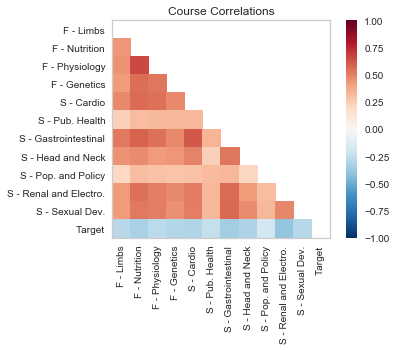

In [70]:

short_names = {
'm1f_limbs'                           : 'F - Limbs',
'm1f_metabolism_nutrition_and_endo'   : 'F - Nutrition',
'm1f_molecular_and_cell_physiology'   : 'F - Physiology',
'm1f_molecular_and_human_genetics'    : 'F - Genetics',
'm1s_cardio_pulmonary'                : 'S - Cardio',
'm1s_ebm_and_population_health'       : 'S - Pub. Health',
'm1s_gastrointestinal'                : 'S - Gastrointestinal',
'm1s_head_neck_and_special_senses'    : 'S - Head and Neck',
'm1s_patients_populations_and_policy' : 'S - Pop. and Policy',
'm1s_renal_and_electrolytes'          : 'S - Renal and Electro.',
'm1s_sexual_dev__and_reproduction'    : 'S - Sexual Dev.',
'danger_student'                      : 'Target'
}

CorrelationPlot(data[list(short_names.keys())].rename(columns = short_names), 
               output = True, filename = 'CourseCorrs.pdf', title = 'Course Correlations')




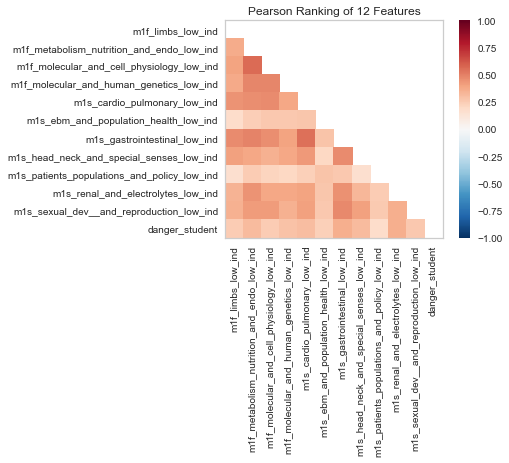

In [73]:
CorrelationPlot(plot_data[low_indicators + ['danger_student']])

### Course Correlation Observations

#### Most Correlated with the rest of the courses
- m1f_molecular_and_cell_physiology
- m1s_renal_and_electrolytes
- m1s_gastrointestinal
- m1s_cardio_pulmonary

#### Least Correlated with the rest of the courses
- m1s_patients_populations_and_policy
- m1s_ebm_and_population_health
- m1f_limbs

### Plot 2B: Other Correlations
#### Transform Plot Data: OneHotEncode

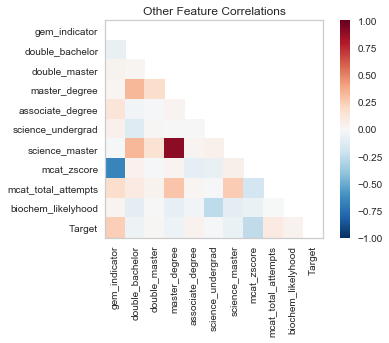

In [74]:
corr_data = data[indicators + continuous + discontinuous + target_elements]
corr_data = corr_data.rename(columns = {'danger_student':'Target'})
CorrelationPlot(corr_data, title = 'Other Feature Correlations')


### Conclusion: 
We may want to take a look at the above chart when putting features into the modes, as it seems some of them are highly correlated. One thing that at first look might interesting is that high/low indicators seem to be less correlated than actual scores. hopefully this these will help our model

## Part 5: 1D Rank Plot


### Function: 1D Rank Plot

In [75]:
def Rank1Dim(feat,targ, output = False):
    X = feat
    y = targ
    visualizer = Rank1D(features = X.columns, algorithm = 'shapiro')
    visualizer.fit(X, y)
    visualizer.transform(X)
    if output == True:
        visualizer.poof(outpath = './visuals/FeatureRank.png')
    else:
        visualizer.poof()

### Call the Plot

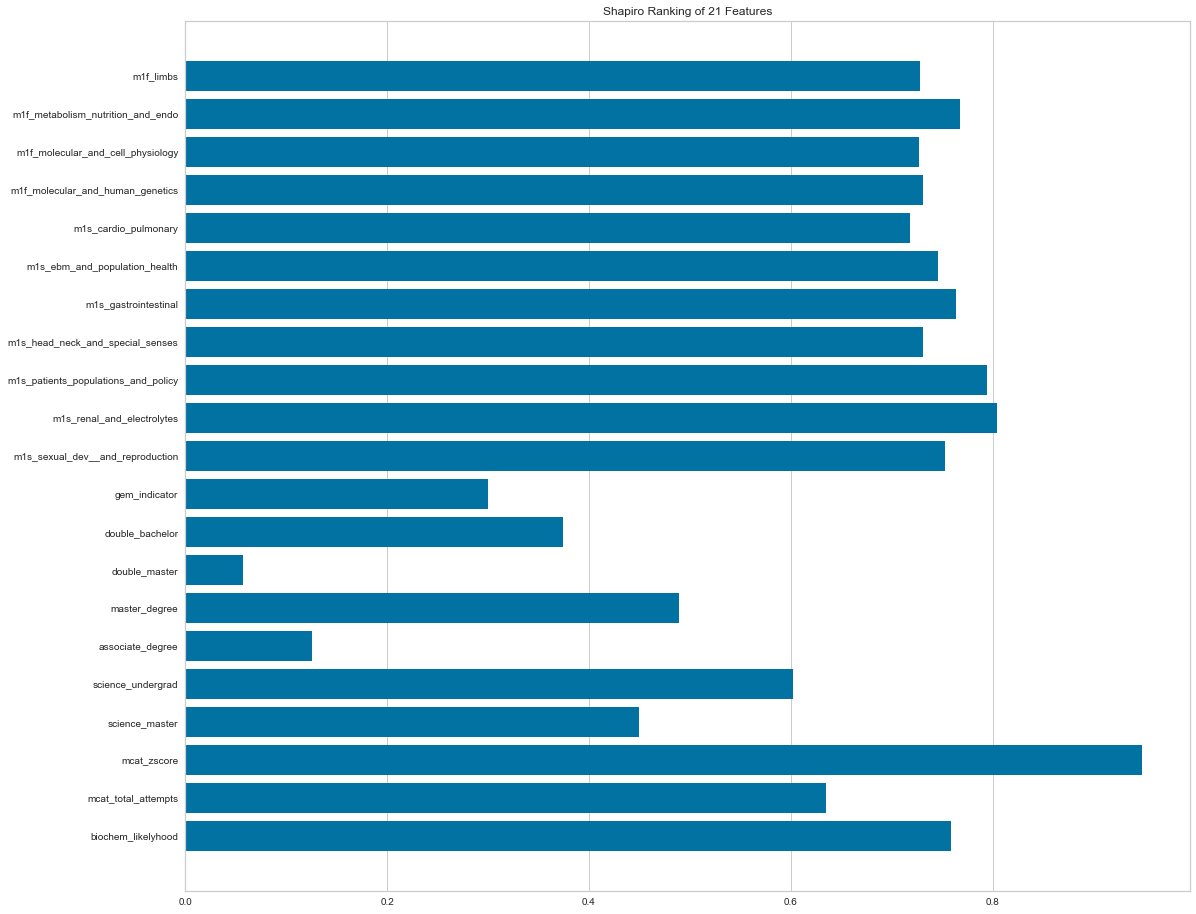

In [81]:
matplotlib.rcParams['figure.figsize'] = [18,16]
Rank1Dim(X,y)

### Try the Plot for Course (pass / low passl).

As we would expect, simplifying our data to pass reduces the power of our model. We should almost certainly stick to the actual scores

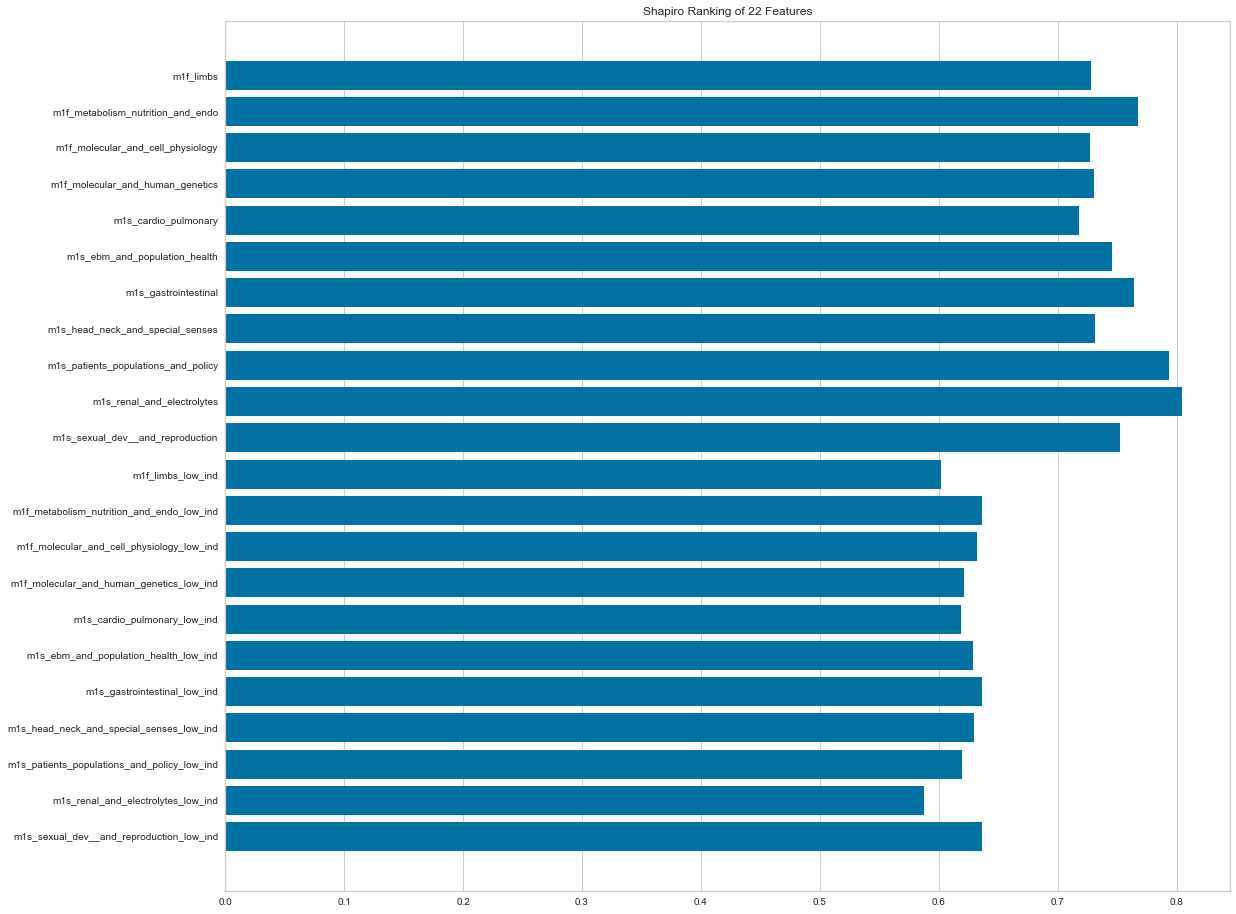

In [97]:
PF = PassFail(courses)
plot_data = PF.fit_transform(X[courses])
Rank1Dim(plot_data, y)


### Conclusion

I we now have a relevant group of features that we can try and use for our machine learning models. I think if we use this information, with some of the correlation information, we might be able to tune our models to perfrom slightly better

## Part Five: Feature Importance Charts
We will try and run the feature importance visualizer for several different machine learning models


In [160]:
def FeatImp(X, y, model, rel= True):
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot()
    viz = FeatureImportances(model, ax=ax, relative = rel)
    viz.fit(X, y)
    viz.poof()

In [161]:
ml_models = {'Linear SVC'  : LinearSVC(), 
          'SVC'            : SVC(),
          'SGD'            : SGDClassifier(),
          'KNeighbors (4)' : KNeighborsClassifier(4),
          'Log. Reg.'      : LogisticRegression(),
          'Bagging'        : BaggingClassifier(),
          'Ex. Trees'      : ExtraTreesClassifier(),
          'RF'             : RandomForestClassifier()
         }

In [195]:
X = data[courses + indicators + continuous + discontinuous].rename(columns = short_names)
y = data['danger_student']



short_names = {
'm1f_limbs'                           : 'F - Limbs',
'm1f_metabolism_nutrition_and_endo'   : 'F - Nutrition',
'm1f_molecular_and_cell_physiology'   : 'F - Physiology',
'm1f_molecular_and_human_genetics'    : 'F - Genetics',
'm1s_cardio_pulmonary'                : 'S - Cardio',
'm1s_ebm_and_population_health'       : 'S - Pub. Health',
'm1s_gastrointestinal'                : 'S - Gastrointestinal',
'm1s_head_neck_and_special_senses'    : 'S - Head and Neck',
'm1s_patients_populations_and_policy' : 'S - Pop. and Policy',
'm1s_renal_and_electrolytes'          : 'S - Renal and Electro.',
'm1s_sexual_dev__and_reproduction'    : 'S - Sexual Dev.',
'danger_student'                      : 'Target'
}

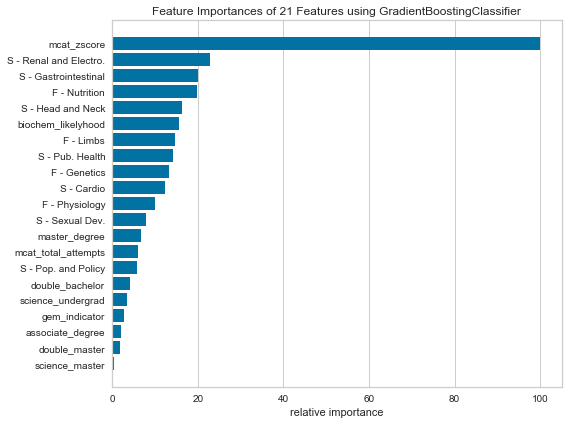

In [196]:
FeatImp(test,y, GradientBoostingClassifier())

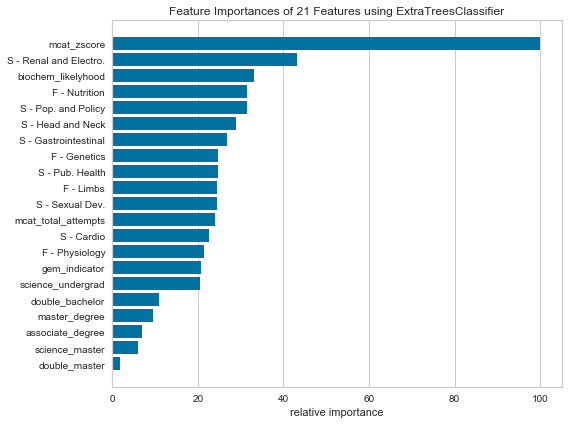

In [197]:
FeatImp(X,y,ExtraTreesClassifier())

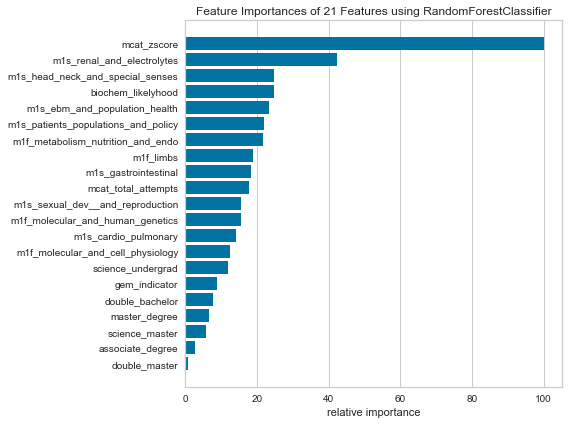

In [165]:
FeatImp(X,y,RandomForestClassifier())

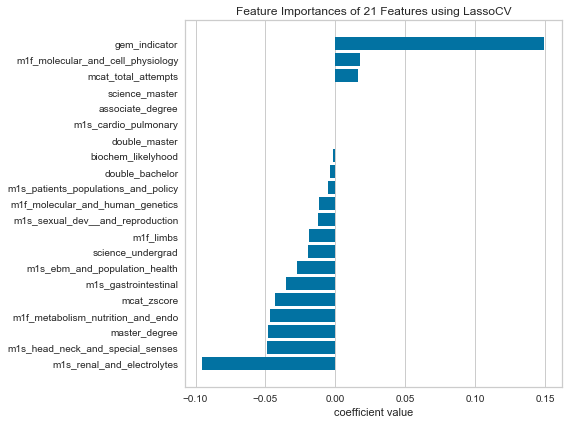

In [189]:
FeatImp(X, y, LassoCV(), rel = False)

In [105]:
m = LogisticRegression()
m.fit(X, y)
print('\nShowing Logistic Regression Coefficients are a list within a list\n')
print(m.coef_)

m = LassoCV()
m.fit(X, y)
print('\nShowing Lasso Coefficients are a regular list\n')
print(m.coef_)


Showing Logistic Regression Coefficients are a list within a list

[[-0.1770525  -0.41428665  0.16739293 -0.13088051 -0.08926694 -0.17989409
  -0.32042847 -0.41186268  0.0128858  -0.46760994 -0.16045827  0.73470644
  -0.19721207  0.05664926 -0.4743523   0.23042177 -0.06648715  0.05988999
  -0.24105363  0.26261067  0.05679712]]

Showing Lasso Coefficients are a regular list

[-0.01859848 -0.0468777   0.01736584 -0.01154933 -0.         -0.02747752
 -0.03545953 -0.04855207 -0.0050599  -0.09508395 -0.0125884   0.14961045
 -0.00352079 -0.         -0.04783837  0.         -0.0192675  -0.
 -0.04332136  0.01606936 -0.00164489]


In [110]:
## Save Use this once the bug is fixed 

#visualizer = FeatureImportances(LogisticRegression(), relative = False)
#visualizer.fit(X, y)
#visualizer.poof()